# Phishing Email Detection – Experiment Pipeline

This notebook runs and compares:
- Traditional Machine Learning models
- LSTM-based Deep Learning model

All experiments are conducted on the same dataset
to ensure a fair comparison.

In [24]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
%matplotlib inline

# Configure plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Paths
DATA_PATH = "../data/processed/emails_merged.csv"
MODEL_DIR = "../models/"
FEATURE_DIR = "../models/features/"
RESULTS_DIR = "../reports/results/"

# 1. LOAD RAW DATA

In [2]:
df_raw = pd.read_csv(DATA_PATH)

print("Raw data shape:", df_raw.shape)
df_raw.head()

Raw data shape: (82486, 7)


,sender,date,subject,body,urls,label,combined_text
0,Young Esposito <Young@iworld.de>,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1.0,1,"Never agree to be a loser Buck up, your troubl..."
1,Mok <ipline's1983@icable.ph>,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1.0,1,Befriend Jenna Jameson \nUpgrade your sex and ...
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1.0,1,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3,Michael Parker <ivqrnai@pobox.com>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,1.0,0,Re: svn commit: r619753 - in /spamassassin/tru...
4,Gretchen Suggs <externalsep1@loanofficertool.com>,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1.0,1,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...


# 2. PREPROCESSING

In [3]:
from src.data.preprocessing import run_preprocessing

df_processed = run_preprocessing(df_raw)

print("After preprocessing:", df_processed.shape)
df_processed.head()

[INFO] Removed 582 samples exceeding 10000 chars
After preprocessing: (81904, 6)


,cleaned_text,label,num_urls,has_url,num_ip_urls,has_ip_url
0,never agree loser buck troubles caused small d...,1,1,1,0,0
1,befriend jenna jameson upgrade sex pleasures t...,1,1,1,0,0
2,cnn com daily top daily top cnn com top videos...,1,24,1,0,0
3,specialpricespharmmoreinfo welcomefastshipping...,1,1,1,0,0
4,caroline aragon yo wu urs mo ou go rc ebo efor...,1,0,0,0,0


# 3. TRAIN/ VAL/ TEST SPLIT 

In [5]:
from src.data.split_data import split_data

splits = split_data(
    df = df_processed,
    label_col="label",
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

X_train = splits["X_train"]
y_train = splits["y_train"]
X_val   = splits["X_val"]
y_val   = splits["y_val"]
X_test  = splits["X_test"]
y_test  = splits["y_test"]

[INFO] Data split completed
  Train: 57332 samples
  Val  : 8191 samples
  Test : 16381 samples
  Label mean (phishing ratio):
    Train: 0.522
    Val  : 0.522
    Test : 0.522


# 4.1. FEATURE EXTRACTION (ML)

In [10]:
from src.features.feature_extraction import FeatureExtractor, FeatureAdapter

extractor = FeatureExtractor(
    text_col="cleaned_text",
    numeric_cols=["num_urls", "num_ip_urls"],
    binary_cols=["has_url", "has_ip_url"],
    max_features=5000,
    ngram_range=(1, 2),
    scale_numeric=True
)

# Fit on training data
features_train = extractor.fit_transform(X_train)
features_val = extractor.transform(X_val)
features_test = extractor.transform(X_test)

# Save extractor
extractor.save(os.path.join(FEATURE_DIR, "feature_extractor.pkl"))

[INFO] FeatureExtractor saved to ../models/features/feature_extractor.pkl


In [12]:
# Adapt features for each model type
ml_features = {}

train_adapted = FeatureAdapter.get_all_adaptations(features_train)
val_adapted = FeatureAdapter.get_all_adaptations(features_val)
test_adapted = FeatureAdapter.get_all_adaptations(features_test)

print("\nFeature dimensions for each model:")
feature_info = FeatureAdapter.get_feature_info(features_train)
for model_type, info in feature_info.items():
    print(f"  {model_type}: {info['n_features']} features (sparsity: {info['sparsity']:.3%})")


Feature dimensions for each model:
  svm: 5002 features (sparsity: 98.699%)
  naive_bayes: 5002 features (sparsity: 98.699%)
  random_forest: 5004 features (sparsity: 98.659%)
  logistic: 5004 features (sparsity: 98.659%)
  combined: 5004 features (sparsity: 98.659%)


# 4.2. SEQUENCE EXTRACTION (LSTM)

In [8]:
from src.features.sequence_extraction import SequenceExtractor

seq_extractor = SequenceExtractor(
    max_words=20000,
    max_len=200,
    oov_token="<OOV>"
)

# Fit and transform
seq_extractor.fit(X_train['cleaned_text'].tolist())

X_train_seq = seq_extractor.transform(X_train['cleaned_text'].tolist())
X_val_seq = seq_extractor.transform(X_val['cleaned_text'].tolist())
X_test_seq = seq_extractor.transform(X_test['cleaned_text'].tolist())

print(f"\nSequences prepared!")
print(f"   Vocabulary size: {seq_extractor.vocab_size():,}")
print(f"   Max length:      {seq_extractor.max_len}")
print(f"   Train shape:     {X_train_seq.shape}")
print(f"   Val shape:       {X_val_seq.shape}")
print(f"   Test shape:      {X_test_seq.shape}")

# Save extractor
seq_extractor.save(os.path.join(FEATURE_DIR, "sequence_extractor.pkl"))

print("Vocab size:", seq_extractor.vocab_size())



Sequences prepared!
   Vocabulary size: 20,000
   Max length:      200
   Train shape:     (57332, 200)
   Val shape:       (8191, 200)
   Test shape:      (16381, 200)
Vocab size: 20000


# 5.1. ML EXPERIMENTS

In [14]:
from src.models.ml_experiment import MLExperiment

ml_models_config = [
    {
        "model_type": "svm",
        "name": "svm_tuned",
        "use_tuning": True,
        "tuning_method": "grid",
        "cv_folds": 3
    },
    {
        "model_type": "random_forest",
        "name": "random_forest_tuned",
        "use_tuning": True,
        "tuning_method": "random",
        "cv_folds": 3

    },
    {
        "model_type": "logistic",
        "name": "logistic_regression_tuned",
        "use_tuning": True,
        "tuning_method": "grid",
        "cv_folds": 3
    },
    {
        "model_type": "naive_bayes",
        "name": "naive_bayes_tuned",
        "use_tuning": True,
        "tuning_method": "grid",
        "cv_folds": 3
    }
]

ml_experiments = {}
ml_metrics = {}
ml_predictions = {}

for config in ml_models_config:
    print(f"\n{'='*40}")
    print(f"Training {config['model_type'].upper()}...")
    print(f"{'='*40}")
    
    experiment = MLExperiment(
        model_type=config["model_type"],
        name=config["name"],
        use_tuning=config["use_tuning"],
        tuning_method=config["tuning_method"],
        cv_folds=config["cv_folds"]
    )
    
    train_history = experiment.train(
        X_train=train_adapted[config["model_type"]],
        y_train=y_train.values,
        X_val=val_adapted[config["model_type"]],
        y_val=y_val.values
    )
    
    val_metrics = experiment.evaluate(
        X=val_adapted[config["model_type"]],
        y=y_val.values
    )
    
    model_path = os.path.join(MODEL_DIR, f"{config['model_type']}_tuned.pkl")
    experiment.save(model_path)
    print(f"✓ Model saved to: {model_path}")
    
    ml_experiments[config["model_type"]] = experiment
    ml_metrics[config["model_type"]] = val_metrics
    
    print(f"Validation Metrics:")
    print(f"  Accuracy:  {val_metrics['accuracy']:.4f}")
    print(f"  Precision: {val_metrics['precision']:.4f}")
    print(f"  Recall:    {val_metrics['recall']:.4f}")
    print(f"  F1-Score:  {val_metrics['f1']:.4f}")
    if 'roc_auc' in val_metrics and val_metrics['roc_auc'] is not None:
        print(f"  ROC-AUC:   {val_metrics['roc_auc']:.4f}")
    
    if 'best_params' in val_metrics:
        print(f"  Best Params: {val_metrics['best_params']}")

print(f"\n{'='*60}")
print("ALL ML MODELS TRAINING COMPLETED!")
print(f"{'='*60}")


Training SVM...
[INFO] Starting GRID search for svm...
[INFO] Grid: {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[SUCCESS] Tuning complete.
   Best Params: {'C': 10.0, 'kernel': 'rbf'}
   Best CV F1:  0.9881
[RESULT] Train Accuracy: 0.9998
[RESULT] Val Accuracy:   0.9872
[INFO] Model saved to ../models/svm_tuned.pkl
✓ Model saved to: ../models/svm_tuned.pkl
Validation Metrics:
  Accuracy:  0.9872
  Precision: 0.9863
  Recall:    0.9892
  F1-Score:  0.9877
  ROC-AUC:   0.9992
  Best Params: {'C': 10.0, 'kernel': 'rbf'}

Training RANDOM_FOREST...
[INFO] Starting RANDOM search for random_forest...
[INFO] Grid: {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[SUCCESS] Tuning complete.
   Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
   Be

# 5.2. DL EXPERIMENT

In [19]:
import importlib
import src.models.dl_experiment 

# Ép buộc tải lại module dl_experiment để nhận diện các thay đổi mới (use_bidirectional)
importlib.reload(src.models.dl_experiment)

# Import lại class sau khi đã reload
from src.models.dl_experiment import LSTMExperiment

In [20]:
from src.models.dl_experiment import LSTMExperiment

dl_config = {
    "model_type": "lstm",
    "name": "lstm_optimized",
    "vocab_size": seq_extractor.vocab_size() + 1,  # +1 for padding token
    "max_len": seq_extractor.max_len,
    "embedding_dim": 128,    
    "lstm_units": 64,        
    "dropout_rate": 0.4,     
    "learning_rate": 0.001,
    "use_bidirectional": True,
    "use_batch_norm": True
}

dl_experiments = {}
dl_metrics = {}

print(f"\n{'='*40}")
print(f"Training {dl_config['model_type'].upper()} (Deep Learning)...")
print(f"{'='*40}")

experiment = LSTMExperiment(
    vocab_size=dl_config["vocab_size"],
    max_len=dl_config["max_len"],
    embedding_dim=dl_config["embedding_dim"],
    lstm_units=dl_config["lstm_units"],
    dropout_rate=dl_config["dropout_rate"],
    learning_rate=dl_config["learning_rate"],
    use_bidirectional=dl_config["use_bidirectional"],
    use_batch_norm=dl_config["use_batch_norm"],
    name=dl_config["name"]
)

train_history = experiment.train(
    X_train=X_train_seq,
    y_train=y_train.values,  
    X_val=X_val_seq,
    y_val=y_val.values,      
    epochs=15,              
    batch_size=64,
    patience=3,              
    save_best=True,
    checkpoint_path=os.path.join(MODEL_DIR, "lstm_best_checkpoint.keras")
)

val_metrics = experiment.evaluate(
    X=X_val_seq,
    y=y_val.values
)

model_path = os.path.join(MODEL_DIR, "lstm_tuned") 
experiment.save(model_path)
print(f"✓ Model saved to: {model_path}")

dl_experiments["lstm"] = experiment
dl_metrics["lstm"] = val_metrics

print(f"Validation Metrics:")
print(f"  Accuracy:  {val_metrics['accuracy']:.4f}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall:    {val_metrics['recall']:.4f}")
print(f"  F1-Score:  {val_metrics['f1']:.4f}")
if 'roc_auc' in val_metrics and val_metrics['roc_auc'] is not None:
    print(f"  ROC-AUC:   {val_metrics['roc_auc']:.4f}")

print(f"  Final Train Loss: {train_history.get('final_train_loss', 0):.4f}")
print(f"  Final Val Loss:   {train_history.get('final_val_loss', 0):.4f}")

print(f"\n{'='*60}")
print("DEEP LEARNING TRAINING COMPLETED!")
print(f"{'='*60}")


Training LSTM (Deep Learning)...

[INFO] Training LSTM with class weights: {0: 1.0465099299065421, 1: 0.9574482297929192}
Epoch 1/15


896/896 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9707
Epoch 1: val_loss improved from inf to 0.05315, saving model to ../models\lstm_best_checkpoint.keras
896/896 [==============================] - 179s 196ms/step - loss: 0.0827 - accuracy: 0.9707 - val_loss: 0.0532 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 2/15
896/896 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.9929
Epoch 2: val_loss improved from 0.05315 to 0.04627, saving model to ../models\lstm_best_checkpoint.keras
896/896 [==============================] - 173s 193ms/step - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.0463 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 3/15
896/896 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9963
Epoch 3: val_loss did not improve from 0.04627
896/896 [=============================

# 6. AGGREGATE RESULTS

In [22]:
final_results = []
for model_type, metrics in ml_metrics.items():
    res = {
        "Model": model_type.upper().replace("_", " "),
        "Type": "Machine Learning",
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1-Score": metrics["f1"],
        "ROC-AUC": metrics.get("roc_auc", 0)
    }
    final_results.append(res)

lstm_metrics = dl_metrics["lstm"]
res_dl = {
    "Model": "Bi-LSTM (Deep Learning)",
    "Type": "Deep Learning",
    "Accuracy": lstm_metrics["accuracy"],
    "Precision": lstm_metrics["precision"],
    "Recall": lstm_metrics["recall"],
    "F1-Score": lstm_metrics["f1"],
    "ROC-AUC": lstm_metrics.get("roc_auc", 0)
}
final_results.append(res_dl)

In [25]:
df_results = pd.DataFrame(final_results).sort_values(by="F1-Score", ascending=False)
print("\n=== BẢNG XẾP HẠNG HIỆU NĂNG (VALIDATION SET) ===")
display(df_results.style.background_gradient(cmap="Greens", subset=["Accuracy", "F1-Score", "ROC-AUC"]))

df_results.to_csv(os.path.join(RESULTS_DIR, "model_comparison.csv"), index=False)


=== BẢNG XẾP HẠNG HIỆU NĂNG (VALIDATION SET) ===


,Model,Type,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,SVM,Machine Learning,0.987181,0.986250,0.989247,0.987747,0.999229
4,Bi-LSTM (Deep Learning),Deep Learning,0.985350,0.984164,0.987845,0.986001,0.998272
2,LOGISTIC,Machine Learning,0.981443,0.980214,0.984338,0.982272,0.998497
1,RANDOM FOREST,Machine Learning,0.981199,0.981551,0.982468,0.982009,0.998052
3,NAIVE BAYES,Machine Learning,0.951776,0.980926,0.925666,0.952495,0.993580


# 7. VISUAL COMPARISON

In [28]:
df_for_eval = df_results.rename(columns={
    "Model": "model",
    "Type": "model_type",
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "F1-Score": "f1",      
    "ROC-AUC": "roc_auc"
})

In [36]:
from src import evaluation

print("\n=== 1. BẢNG XẾP HẠNG MODEL ===")
ranked_df = evaluation.rank_models(df_for_eval, by="f1", ascending=False)
display(ranked_df.style.background_gradient(cmap="Greens", subset=["f1"]))


=== 1. BẢNG XẾP HẠNG MODEL ===


,model,model_type,f1,rank
0,SVM,Machine Learning,0.987747,1
4,Bi-LSTM (Deep Learning),Deep Learning,0.986001,2
2,LOGISTIC,Machine Learning,0.982272,3
1,RANDOM FOREST,Machine Learning,0.982009,4
3,NAIVE BAYES,Machine Learning,0.952495,5



=== 2. BIỂU ĐỒ SO SÁNH F1-SCORE ===
Image saved to: ../reports/results/f1_score_comparison.png


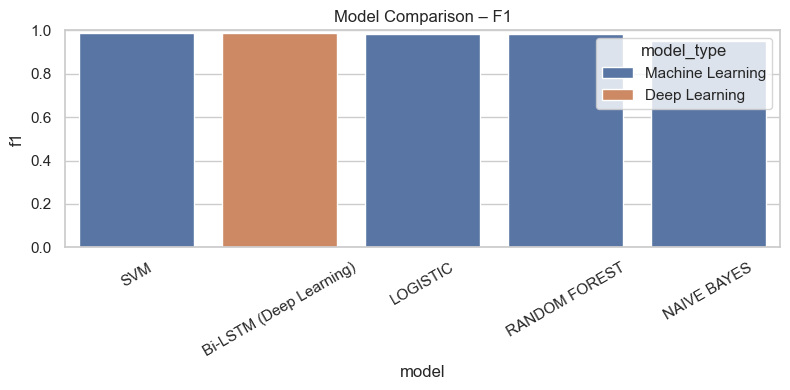

In [37]:
f1_chart_path = os.path.join(RESULTS_DIR, "f1_score_comparison.png")

print("\n=== 2. BIỂU ĐỒ SO SÁNH F1-SCORE ===")
evaluation.plot_metric_bar(df_for_eval, metric="f1", save_path=f1_chart_path)


=== 3. SO SÁNH ĐA CHỈ SỐ ===
Image saved to: ../reports/results/multi_metric_comparison.png


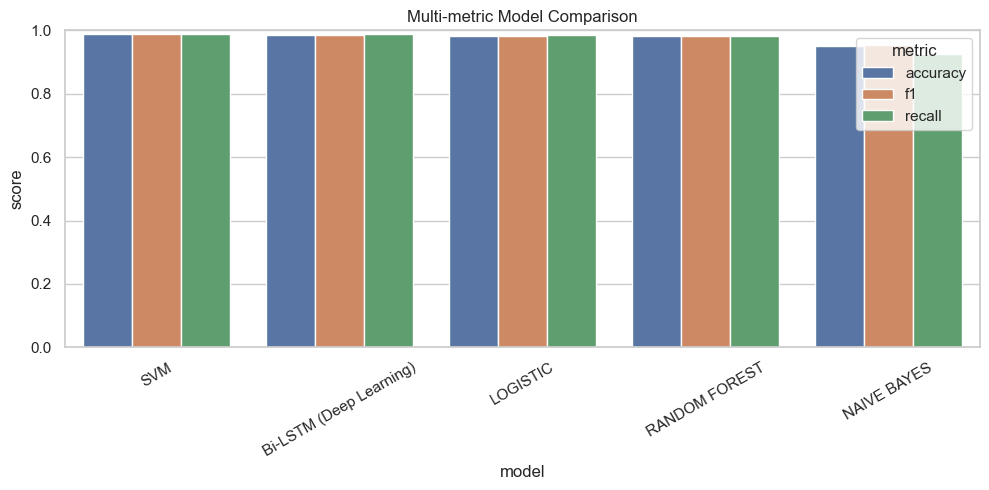

In [38]:
print("\n=== 3. SO SÁNH ĐA CHỈ SỐ ===")
multi_metric_chart_path = os.path.join(RESULTS_DIR, "multi_metric_comparison.png")
evaluation.plot_metric_group(df_for_eval, metrics=["accuracy", "f1", "recall"], save_path=multi_metric_chart_path)


=== 4. CONFUSION MATRIX (BEST MODEL) ===
Model tốt nhất: SVM
Image saved to: ../reports/results/confusion_matrix_best_model.png


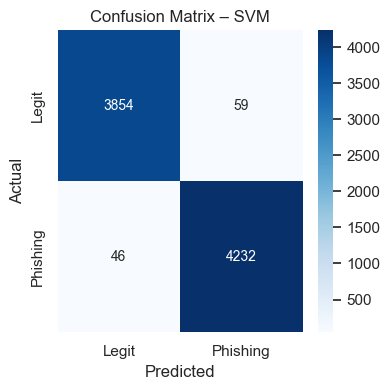

In [40]:
print("\n=== 4. CONFUSION MATRIX (BEST MODEL) ===")
best_model_name = ranked_df.iloc[0]['model']
print(f"Model tốt nhất: {best_model_name}")

if "LSTM" in best_model_name or "Deep Learning" in best_model_name:
    cm = dl_metrics['lstm']['confusion_matrix']
else:
    key_guess = best_model_name.lower().replace(" ", "_")
    real_key = [k for k in ml_metrics.keys() if k in key_guess]
    real_key = real_key[0] if real_key else list(ml_metrics.keys())[0] 
    cm = ml_metrics[real_key]['confusion_matrix']

evaluation.plot_confusion_matrix(cm, model_name=best_model_name, save_path=os.path.join(RESULTS_DIR, "confusion_matrix_best_model.png"))